In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_synthetic_data(p, n, d, g):
    
    y = np.random.binomial(1, p, size=n)
    
    S = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            S[i, j] = g ** abs(i - j)
    
    mean_Y0 = np.zeros(d)
    mean_Y1 = np.array([1 / (i + 1) for i in range(d)])
    
    X = np.zeros((n, d))
    for i in range(n):
        if y[i] == 0:
            X[i] = np.random.multivariate_normal(mean_Y0, S)
        else:
            X[i] = np.random.multivariate_normal(mean_Y1, S)

    X = np.hstack((np.ones((n, 1)), X))
    
    return X, y


In [31]:
class LogRegCCD:
    def __init__(self, alpha=0.5, tol=1e-6, max_outer=100, max_inner=1000):
        self.alpha = alpha
        self.tol = tol
        self.max_outer = max_outer
        self.max_inner = max_inner
        self.best_lambda = None
        self.best_beta = None

    def S(self, z, gamma):
        return np.sign(z) * max(np.abs(z) - gamma, 0)
    
    def coordinate_descent(self, X, y, w, lambd, beta):
        N, p = X.shape
        for inner_iteration in range(self.max_inner):
            beta_old = beta.copy()
            for j in range(p):
                residual = y - X @ beta + beta[j] * X[:, j]
                rho = (1 / N) * np.sum(w * X[:, j] * residual)
                beta[j] = self.S(rho, lambd * self.alpha) / (1 + lambd * (1 - self.alpha))
            
            if np.linalg.norm(beta - beta_old, ord=2) < self.tol:
                break
        return beta

    def fit(self, X_train, y_train, lambdas, metric = accuracy_score):
        N, p = X_train.shape
        best_metric_value = -np.inf
        
        for lambd in lambdas:
            beta = np.zeros(p)
            for outer_iteration in range(self.max_outer):
                eta = X_train @ beta
                p_tilde = 1 / (1 + np.exp(-eta))
                w = p_tilde * (1 - p_tilde)
                z = X_train @ beta + (y_train - p_tilde) / np.maximum(w, 1e-6)
                beta = self.coordinate_descent(X_train, z, w, lambd, beta)

            preds = (X_train @ beta > 0).astype(int)
            metric_value = metric(y_train, preds)
            if metric_value > best_metric_value:
                best_metric_value = metric_value
                self.best_beta = beta
                self.best_lambda = lambd
            
        
    def validate(self, X_valid, y_valid, measure = accuracy_score):
        if self.best_beta is None:
            raise ValueError("Model is not trained yet")
        
        probs = 1 / (1 + np.exp(-X_valid @ self.best_beta))
        preds = (probs > 0.5).astype(int)
        
        return measure(y_valid, preds)
    
    def predict_proba(self, X_test):
        if self.best_beta is None:
            raise ValueError("Model is not trained yet")
        return 1 / (1 + np.exp(-X_test @ self.best_beta))
    
    def plot(self, measure, X_train, y_train, X_valid, y_valid, lambdas):
        scores = []
        for lambd in lambdas:
            self.fit(X_train, y_train, [lambd])
            score = self.validate(X_valid, y_valid, measure)
            scores.append(score)
        plt.plot(lambdas, scores, marker='o')
        plt.xlabel("Lambda")
        plt.ylabel(measure.__name__)
        plt.title(f"{measure.__name__} vs Lambda")
        plt.show()
    
    def plot_coefficients(self, lambdas, X_train, y_train):
        coefficients = []
        for lambd in lambdas:
            self.fit(X_train, y_train, [lambd])
            coefficients.append(self.best_beta.copy())
        coefficients = np.array(coefficients)
        for i in range(coefficients.shape[1]):
            plt.plot(lambdas, coefficients[:, i], label=f'Feature {i}')
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficients based on lambdas")
        plt.legend()
        plt.show()

In [33]:
p = 0.5  # Class prior probability
n = 10000  # Number of samples
d = 6    # Dimension
g = 0.7  # Covariance matrix multiplier

X, y = generate_synthetic_data(p, n, d, g)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Standard logistic regression
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
sklearn_beta = log_reg.coef_[0]
sklearn_preds = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, sklearn_preds)

# ElasticNet logistic regression
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
elastic_net_preds = elastic_net.predict(X_test)
elastic_net_preds = (elastic_net_preds > 0).astype(int)
accuracy_elastic_net = accuracy_score(y_test, elastic_net_preds)

# LogRegCCD
log_reg_ccd = LogRegCCD()
log_reg_ccd.fit(X_train, y_train, [i/10 for i in range(0, 50)])
accuracy_log_reg_ccd = log_reg_ccd.validate(X_test, y_test, accuracy_score)

print("Accuracy of sklearn Logistic Regression:", accuracy_log_reg)
print("Accuracy of minimize elastic:", accuracy_elastic_net)
print("Accuracy of Logistic Regression CCD:", accuracy_log_reg_ccd)

Accuracy of sklearn Logistic Regression: 0.688
Accuracy of Logistic Regression CCD: 0.674
Accuracy of minimize elastic: 0.688


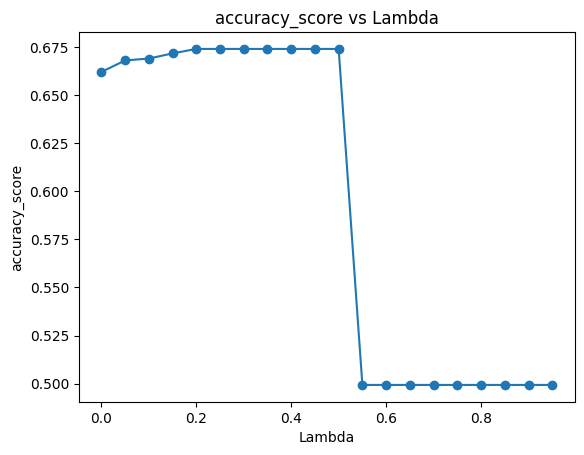

In [35]:
log_reg_ccd.plot(accuracy_score, X_train, y_train, X_test, y_test, [i/20 for i in range(0, 20)])

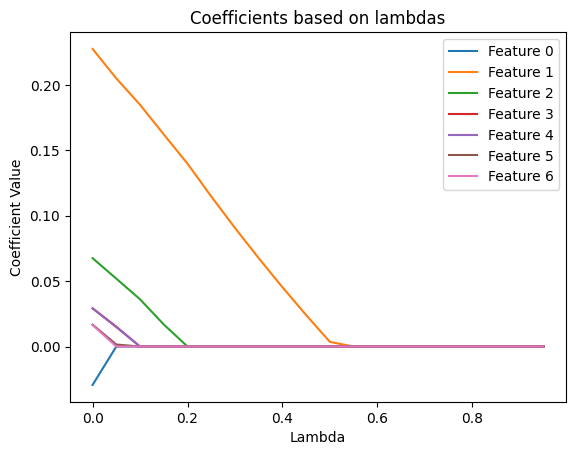

In [36]:
log_reg_ccd.plot_coefficients([i/20 for i in range(0, 20)], X_train, y_train)